
### Source 
[Here](https://github.com/Xianzhiwang1/CS0451-page-site/tree/main/posts/) is a link to the source code for this blog post.

### Introduction.

### Implementation 

In [1]:
%load_ext autoreload
%autoreload 2

First, let's import some libraries that we need.

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In the following code cell, we will generate a linearly separable dataset of binary-labeled 2D points. The `make_blobs` function essentially takes $n$ samples, a number of features, and classes, and spits out a dataset of points with a data set with the given size, and label the data points using the classes. Visually, we see two clusters of points of two different color. In this special case where I set the seed, those two clusters seems linearly separable, which just means we could draw a straight line that completely seprates them. If we go to higher dimensions, then we need precise mathematical definitions, but we don't need to worry about that right now.

# Getting the data using `folktables`

In [4]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter

STATE = "IN"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

In [5]:
acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000042,3,1,2000,2,18,1013097,46,20,...,7,6,82,44,6,76,83,44,45,44
1,P,2018GQ0000053,3,1,2306,2,18,1013097,19,48,...,16,19,37,23,2,19,2,2,40,18
2,P,2018GQ0000074,3,1,2000,2,18,1013097,88,20,...,166,158,160,90,87,84,88,90,13,166
3,P,2018GQ0000118,3,1,401,2,18,1013097,72,20,...,11,10,11,11,71,11,70,11,74,135
4,P,2018GQ0000319,3,1,200,2,18,1013097,97,22,...,15,170,93,181,175,92,174,16,96,95


# Replication
<p>One of our reference is this <a href="https://arxiv.org/pdf/2108.04884.pdf"> paper</a> that introduced the package.</p>
<p>Here are some of the variables that are important for our analysis</p>

<li><code>PINCP</code> is total personal income, and we code it as a dummy variable, meaning we label it <code>1</code> when <code>PINCP > 50000</code>, and <code>0</code> otherwise.
<li><code>ESR</code> is employment status coded as a dummy variable (1 if employed, 0 if not)</li>
<li><code>RAC1P</code> is race (<code>1</code> for White Alone, <code>2</code> for Black/African American alone, <code>3</code> and above for other self-identified racial groups)</li>
<li><code>SEX</code> is binary sex (1 for male, 2 for female)</li>
<li><code>DEAR</code>, <code>DEYE</code>, and <code>DREM</code> relate to certain disability statuses.</li>


* `AGEP` is Age, represented as integers.
* `SCHL` is educational attainment, coded as integers.
* `MAR` is Marital status, coded using integers.
* `RELP` is Relationship.
* `COW` is class of worker, coded using integers.
* `OCCP` is occupation.
* `POBP` is place of birth.
* `WKHP` is usual hours worked per week in the past 12 months.  


<p>Let’s consider the following task: we are going to</p>

<li>Train a machine learning algorithm to predict whether someone is currently employed, based on their other attributes <em>not</em> including race, and</li>
<li>Perform a bias audit of our algorithm to determine whether it displays racial bias.</li>

<p>First, let’s be more specific:</p>

In [6]:
my_features=['PINCP', 'ESR', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
new_df = acs_data[my_features]
new_df['INCOME'] = np.where(new_df['PINCP'] >= 70000, 1, 0)

/var/folders/py/q89_57zx5wbchyh0d30zhprc0000gn/T/ipykernel_49657/2512992985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['INCOME'] = np.where(new_df['PINCP'] >= 70000, 1, 0)


In [7]:
# new_df.loc[new_df['PINCP'] >= 70000]
new_df.loc[new_df['ESR'] == 1]

,PINCP,ESR,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,INCOME
6,200.0,1.0,19,19.0,5,17,1,NaN,1,3.0,4.0,4,1,2,2,1.0,2,1,0
9,3000.0,1.0,18,18.0,5,17,2,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,0
12,3000.0,1.0,21,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,0
14,38300.0,1.0,56,15.0,5,17,1,NaN,1,1.0,4.0,3,1,2,2,1.0,1,1,0
16,5000.0,1.0,19,19.0,5,17,2,NaN,1,1.0,4.0,4,1,2,2,2.0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67667,28600.0,1.0,33,16.0,5,13,2,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,0
67669,45000.0,1.0,27,19.0,1,1,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,0
67673,90000.0,1.0,42,22.0,1,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,2,1
67674,22000.0,1.0,46,22.0,1,1,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,2,0


In [8]:
features_to_use = [f for f in my_features if f not in ["ESR", "RAC1P"]]

In [9]:
print(features_to_use)

['PINCP', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']


In [10]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    # group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [11]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Working with `pd.DataFrame`, apply logistic regression in Python with scikit-learn.

In [12]:

df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [13]:
df.loc[df['label'] == False]

,PINCP,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,0.0,31.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,False
2,0.0,2.0,0.0,5.0,2.0,2.0,5.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,0.0,1.0,1,False
3,0.0,14.0,9.0,5.0,2.0,2.0,7.0,1.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False
5,45000.0,38.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
7,7850.0,36.0,17.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54134,30000.0,68.0,17.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1,False
54136,0.0,72.0,19.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,2.0,2.0,1,False
54139,5600.0,20.0,16.0,5.0,5.0,2.0,0.0,1.0,3.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,1,False
54140,0.0,4.0,2.0,5.0,2.0,2.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,0.0,1.0,1,False


In [14]:

# model = make_pipeline(StandardScaler(), LogisticRegression())
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [15]:
y_hat = model.predict(X_test)

In [16]:
print((y_hat == y_test).mean(),
(y_hat == y_test)[group_test == 1].mean(),
(y_hat == y_test)[group_test == 2].mean())

0.8331855791962175 0.8338424983027835 0.8265086206896551


## What's next

# Audit the model

In [17]:
model.score(X_test, y_test)

0.8331855791962175

In [18]:

for obj in [features, label, group]:
  print(obj.shape)

print(features)
print(group)
print(label)

(67680, 16)
(67680,)
(67680,)
[[1.70e+03 2.00e+01 1.90e+01 ... 2.00e+00 2.00e+00 2.00e+00]
 [9.80e+03 4.80e+01 1.30e+01 ... 2.00e+00 1.00e+00 2.00e+00]
 [3.50e+03 2.00e+01 1.90e+01 ... 2.00e+00 2.00e+00 1.00e+00]
 ...
 [2.11e+04 6.70e+01 1.60e+01 ... 1.00e+00 2.00e+00 1.00e+00]
 [8.40e+03 6.70e+01 1.90e+01 ... 2.00e+00 2.00e+00 2.00e+00]
 [5.50e+04 6.70e+01 2.10e+01 ... 2.00e+00 2.00e+00 1.00e+00]]
[9 1 1 ... 1 1 1]
[False False False ... False False  True]


Recall that:
* upper-left corner is `TN`, which stands for `True negative`
* lower-left corner is `FN`, `False negative` 
* upper-right corner is `FP`, which stands for `False positive`
* lower-right corner is `TP`, `True positive` 


We also care about the `FPR`, which stands for the false positive rate, which is top-right corner of the confusion matrix (after we normalize).  `FNR` is false negative rate.

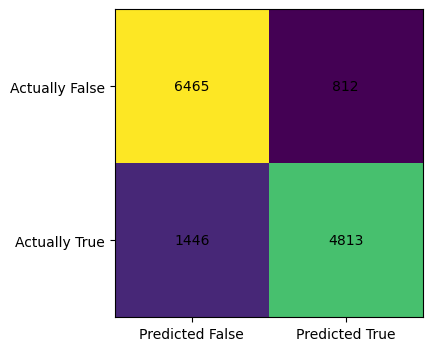

In [19]:
my_matr = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j], ha='center', va='center', color='black')

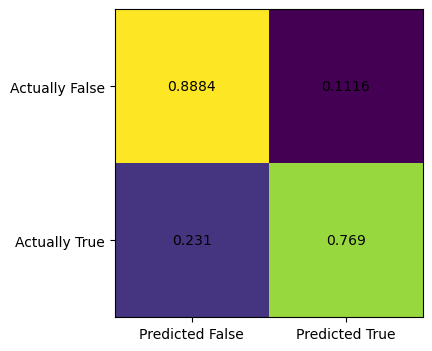

In [20]:

my_matr = confusion_matrix(y_test, model.predict(X_test), normalize="true")
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j].round(4), ha='center', va='center', color='black')